In [1]:
import random as r
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import networkx as nx
from networkx.algorithms.assortativity import neighbor_degree

In [27]:
np.random.uniform()

0.7114403223676837

# 실패작

In [10]:
def temp(l, m, n, gamma, alpha):


   # make triangular lattice
   G = nx.triangular_lattice_graph(m=l, n=m, periodic=False, with_positions=True, create_using=None)
   pos = nx.get_node_attributes(G, 'pos')


   # occupied : 0 = susceptible cells state
   nx.set_node_attributes(G=G,
                            values = {(i,j):{'occupied':0} for i,j in G.nodes})


    # center는 무조건 걸리게 해뒀음 나중에는 바꿀 꺼임
   center = (l//2, l//2)
   G.nodes[center]['occupied'] = 2
    
    # # 초기에 나오는 seed값을 정해보고 상태를 바꾼다\n",
    # for i in range(seed_number):\n",
    #     # 지금은 가장자리에 잘 안 분포되게 해놓는게 좋을 거 같아서 1 l로 범위를 잡아높고 나중에 uniform distribution같은걸로 값을 넣어주는게 필요할 듯\n",
    #     G.nodes[(r.randrange(1,l),r.randrange(1,l))]['occupied'] = 1\n",
    

   sus_list = []
   exposed_list = []
   infected_list = []
   dead_list = []
   step=0
    
   while(step < n):
      
      # neighbors는 스텝에 따라서 달라질 수 있기 때문에 초기에 다시 세팅해야됨\n",
      neighbors_list=[]
      
      # set을 사용하는 이유는 중복을 없애기 위해서다.
      exposed_set = set()
      infected_set = set()
      
      # 현재 노드 상태를 확인해보자
      sus_nodes = [i for i,j in G.nodes(data=True) if G.nodes[(i)]['occupied'] == 0]
      exposed_nodes = [i for i,j in G.nodes(data=True) if G.nodes[(i)]['occupied'] == 1]
      infected_nodes = [i for i,j in G.nodes(data=True) if G.nodes[(i)]['occupied'] == 2]
      dead_nodes = [i for i,j in G.nodes(data=True) if G.nodes[(i)]['occupied'] == 3]

      sus_list.append(sus_nodes)
      exposed_list.append(exposed_nodes)
      infected_list.append(infected_nodes)
      dead_list.append(dead_nodes)
      

      for i in infected_nodes:
         neighbors_list.append([n for n in G.neighbors(i)])
         # if (neighbors_list[0] == 1):
         #    G.nodes[i]['occupied'] = 3


      for i in neighbors_list:
         # for k in range(len(neighbors_list)):
         #    G.nodes[[n for n in G.neighbors(i)][1]]['occupied']
         for j in i:
            exposed_set.add(tuple(j*np.random.choice([0,1], 1, p = [1-alpha, alpha])))



      for i in exposed_list:
         infected_set.add(tuple(i*np.random.choice([0,1],1, p=[1-gamma, gamma])))


      exposed_set.discard((0,0))
      infected_set.discard((0,0))

      for i in list(exposed_set):
         G.nodes[(i)]['occupied'] = 1
         
      for i in list(infected_set):
         G.nodes[(i)]['occupied'] = 2

      
      step += 1

   return sus_list, infected_list, exposed_list,dead_list, G, pos

In [11]:
l = 40
m = 80
n=10
# seed_number = 5

gamma=0.2
alpha = 0.3

s_nodes, i_nodes, e_nodes, d_nodes, G, pos = temp(l,m,n,alpha,gamma)

KeyError: ()

In [87]:
s_plot = []

for i in range(n):
    s_plot.append(len(s_nodes[i]))

e_plot = []

for i in range(n):
    e_plot.append(len(e_nodes[i]))

i_plot = []
for i in range(n):
    i_plot.append(len(i_nodes[i]))

d_plot = []

for i in range(n):
    d_plot.append(len(d_nodes[i]))

# 메인 코드

/var/folders/7w/f3yz5lls31n4jsq13_dmd6z40000gn/T/ipykernel_39267/1272036789.py:180: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


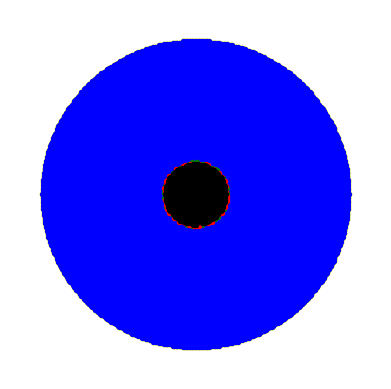

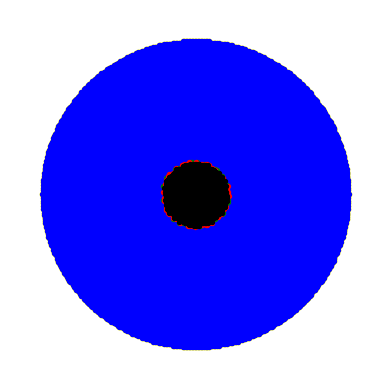

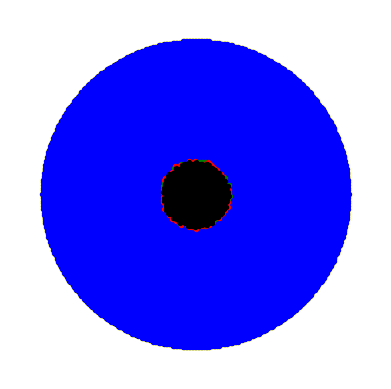

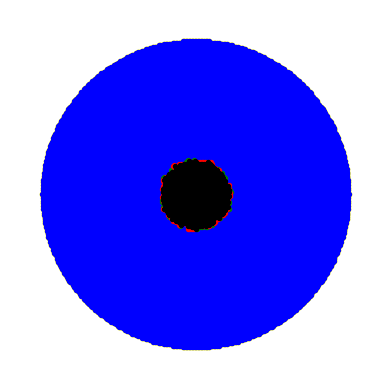

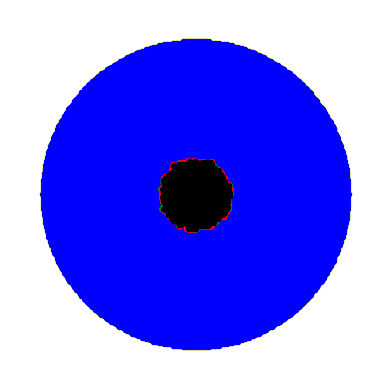

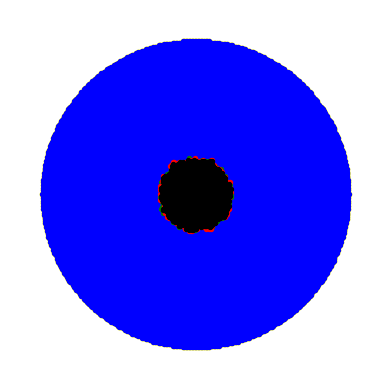

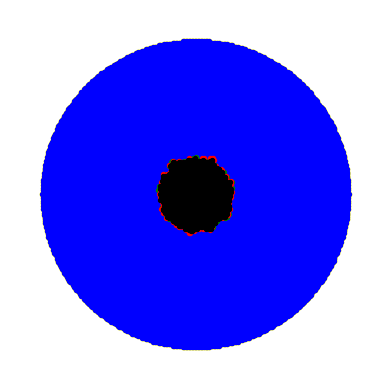

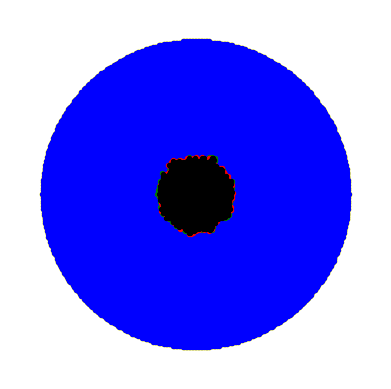

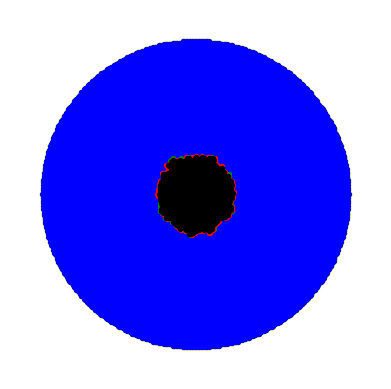

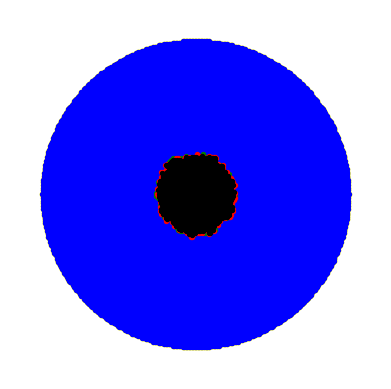

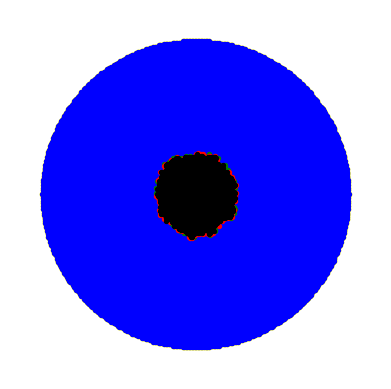

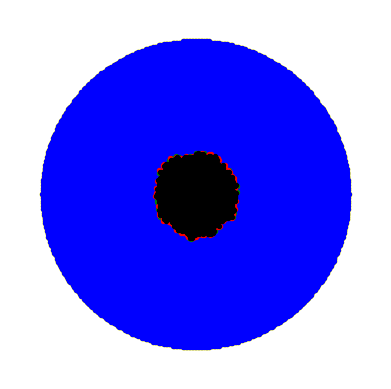

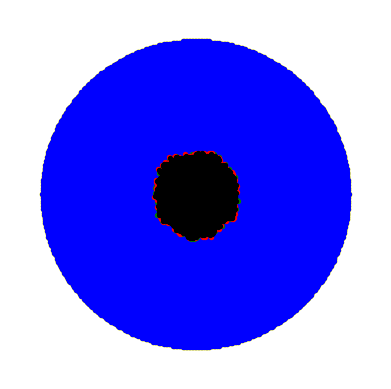

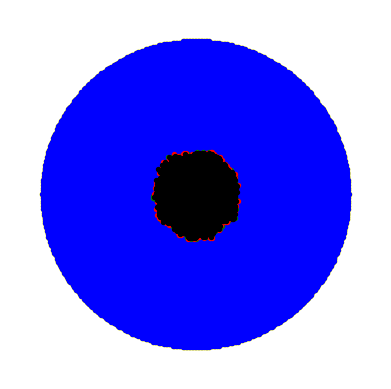

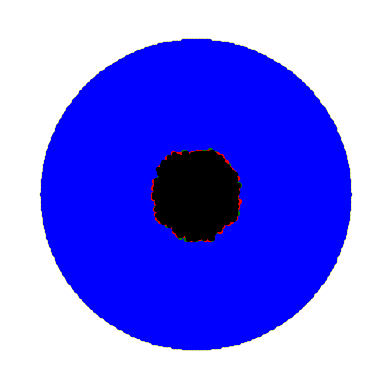

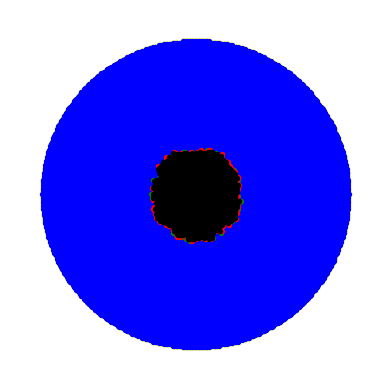

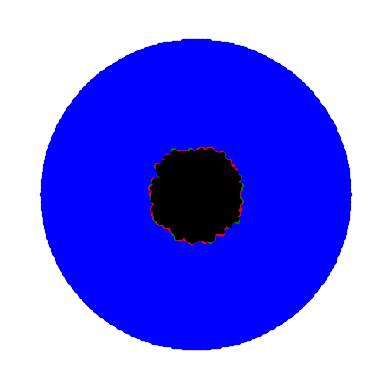

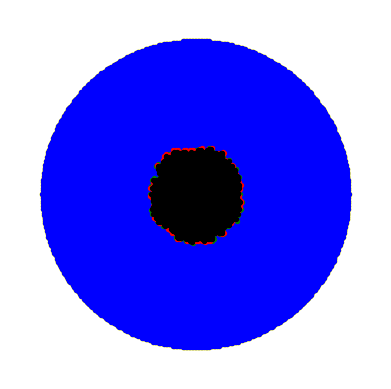

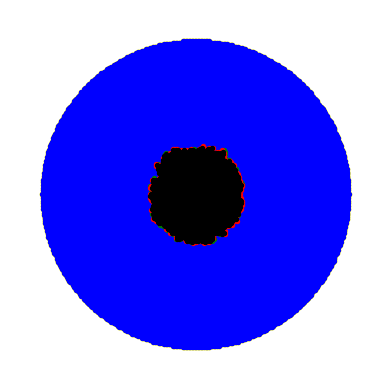

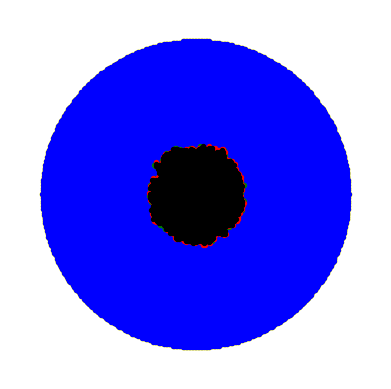

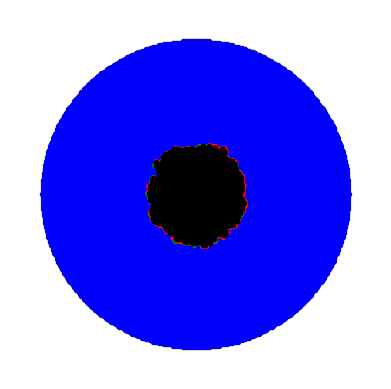

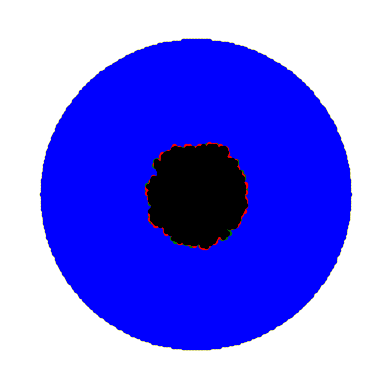

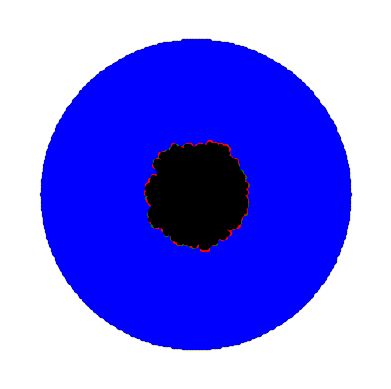

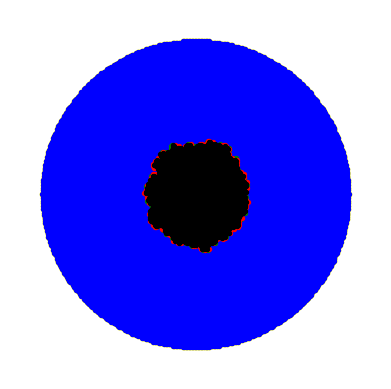

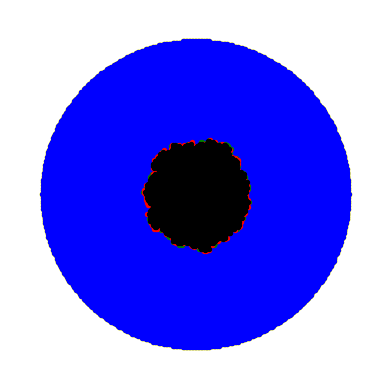

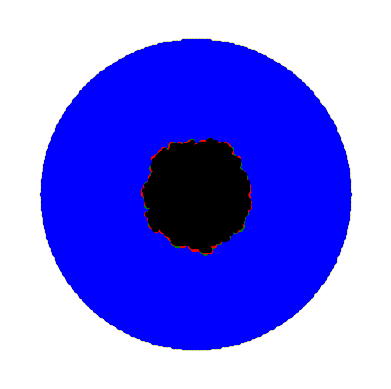

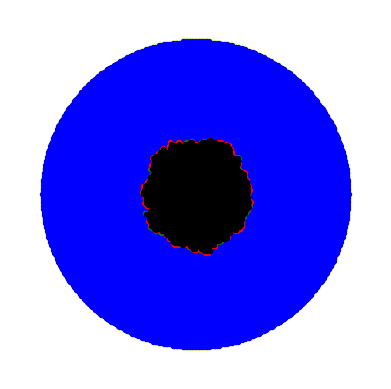

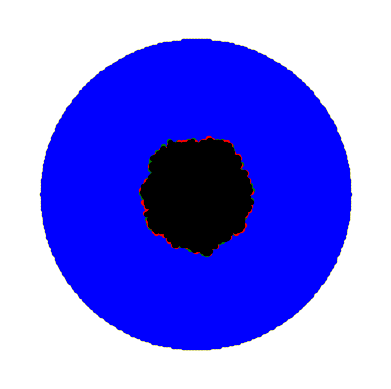

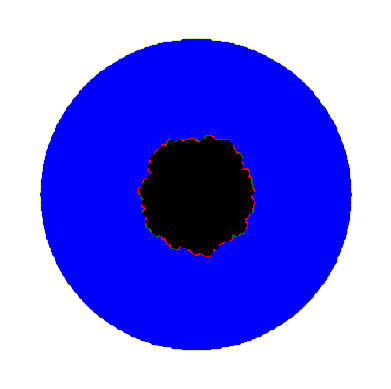

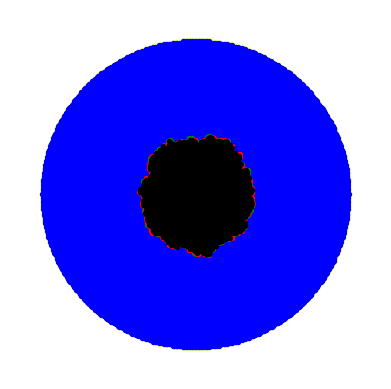

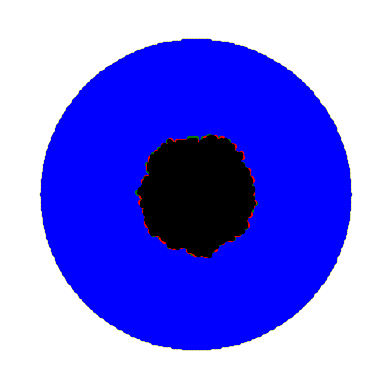

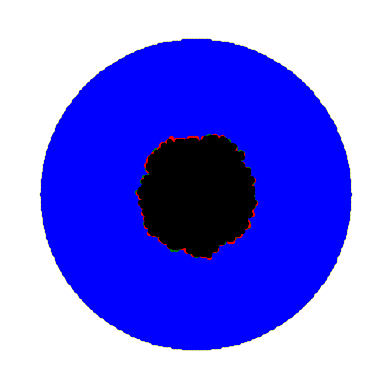

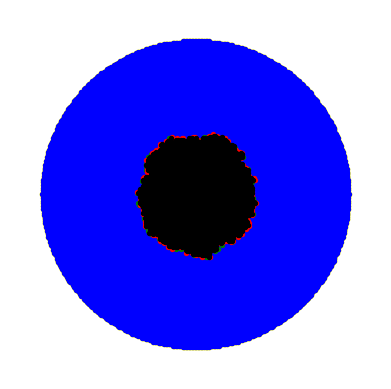

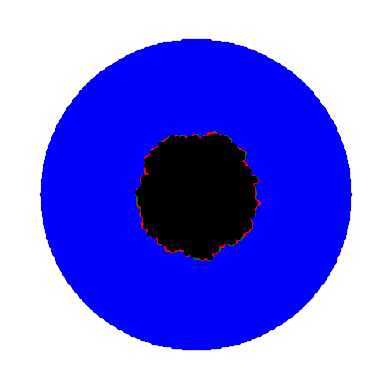

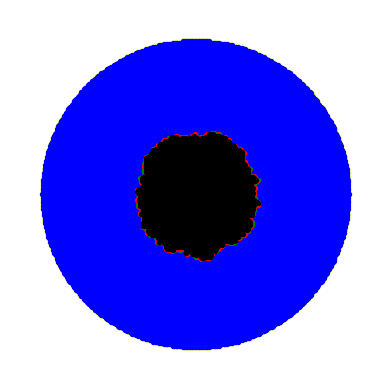

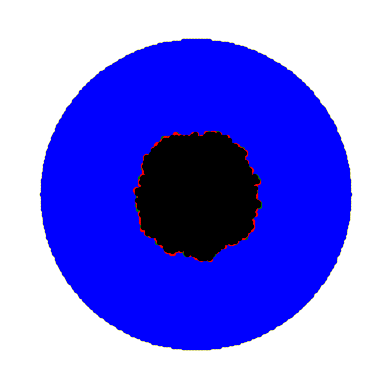

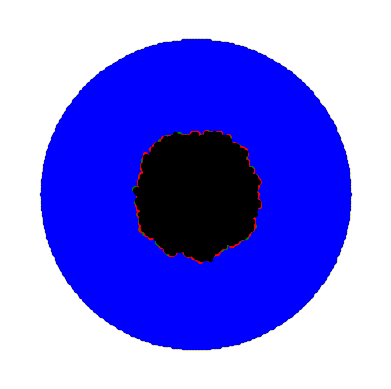

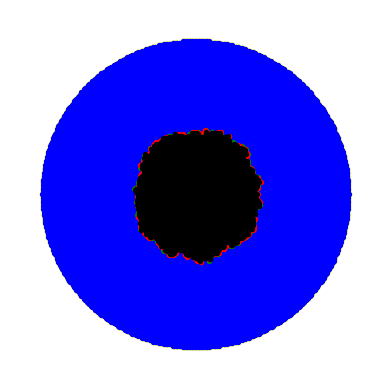

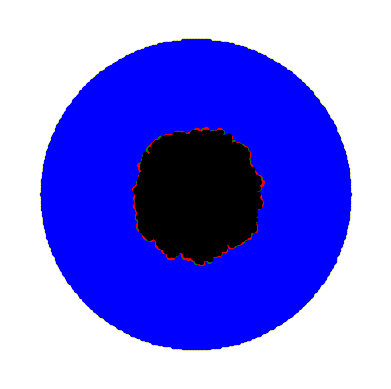

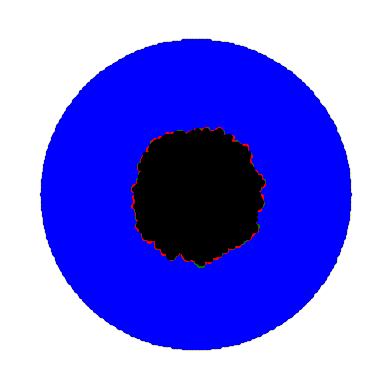

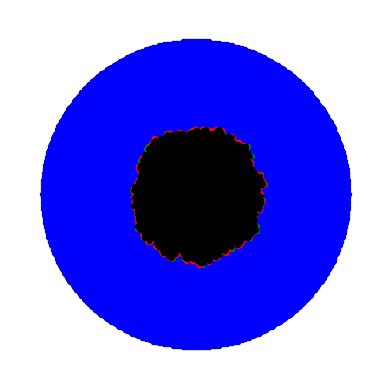

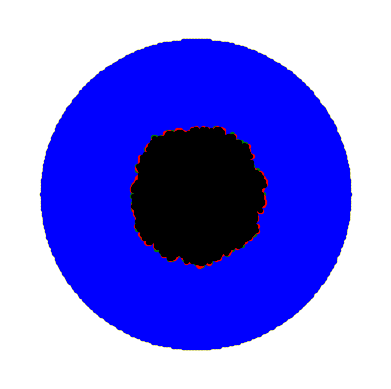

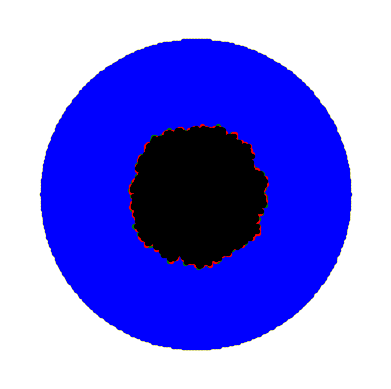

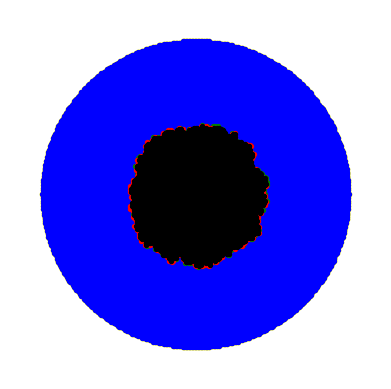

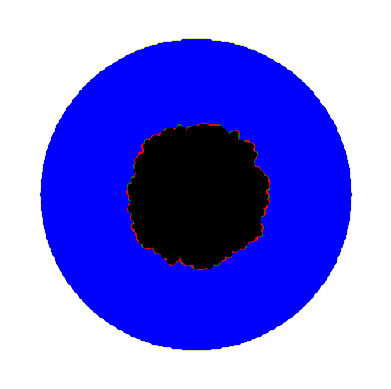

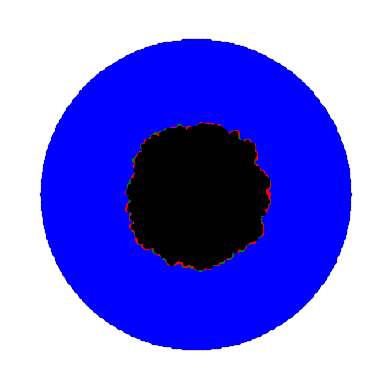

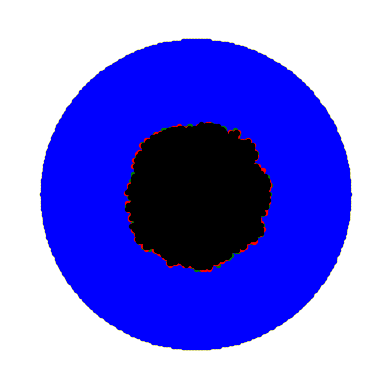

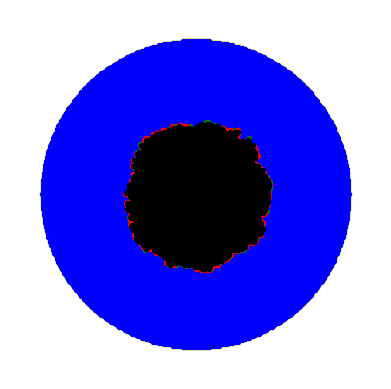

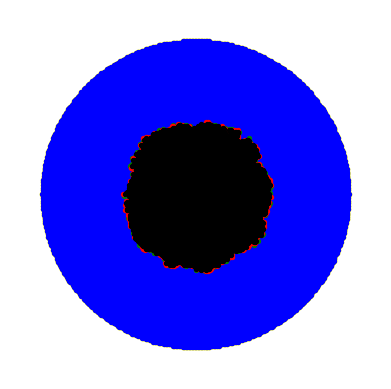

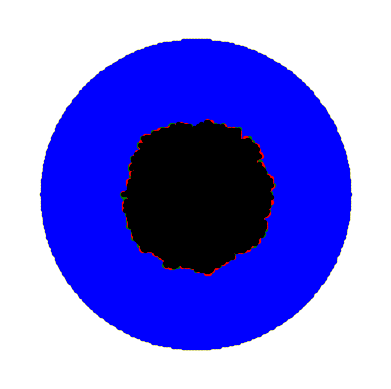

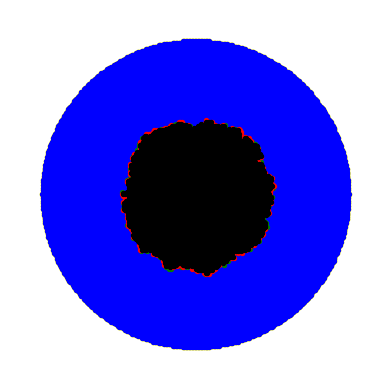

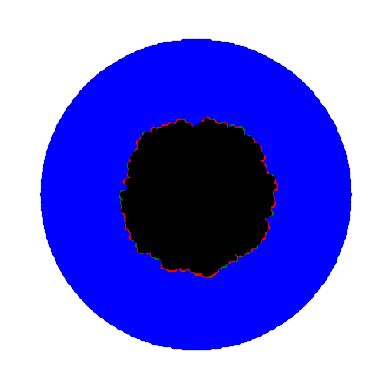

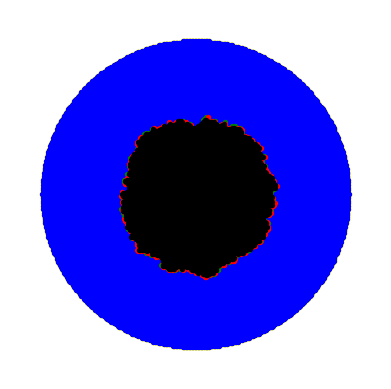

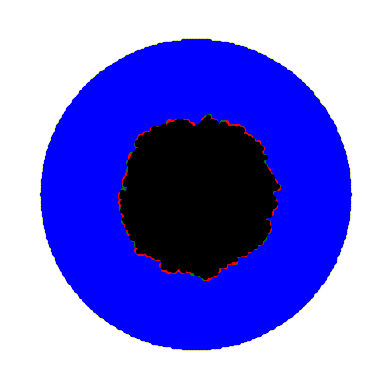

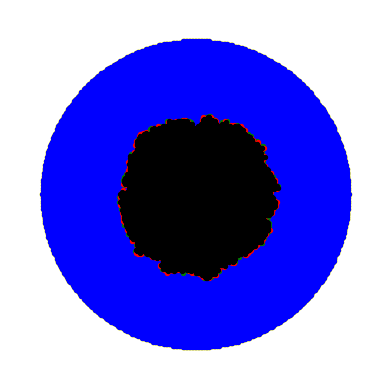

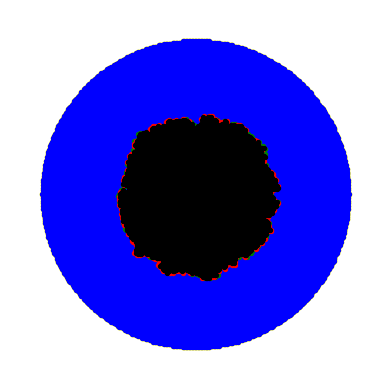

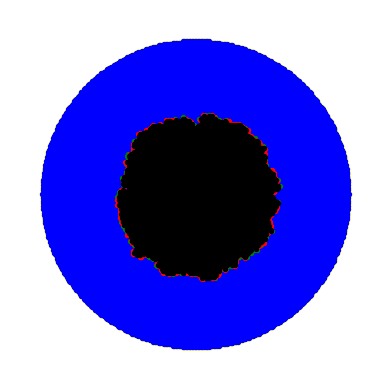

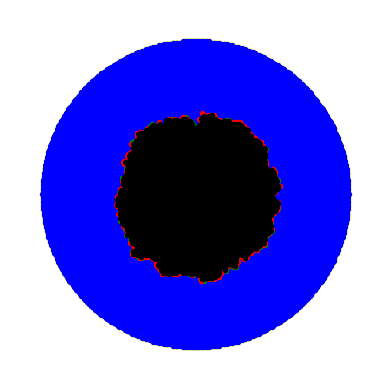

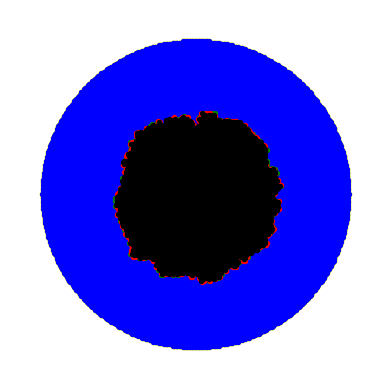

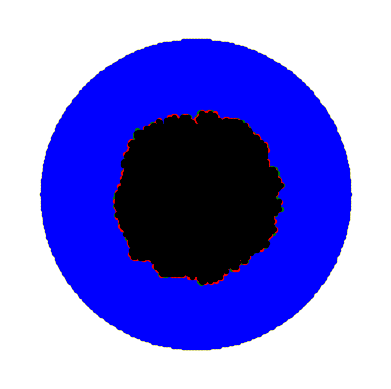

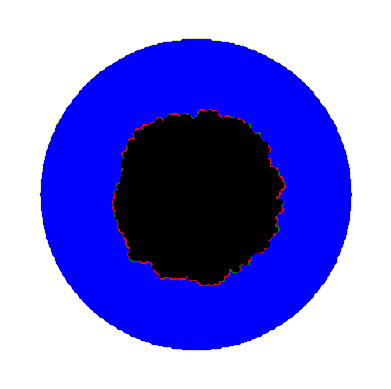

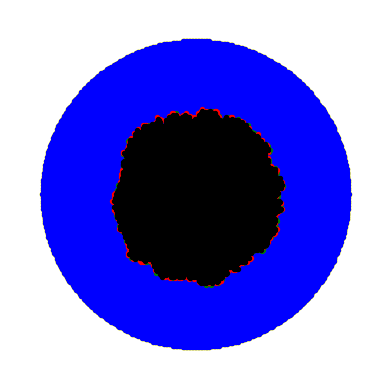

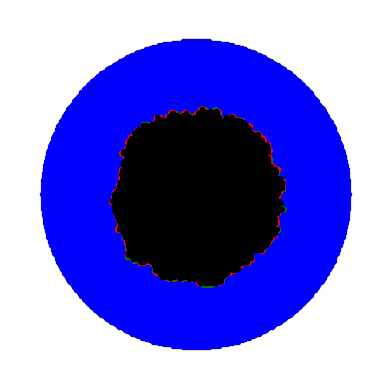

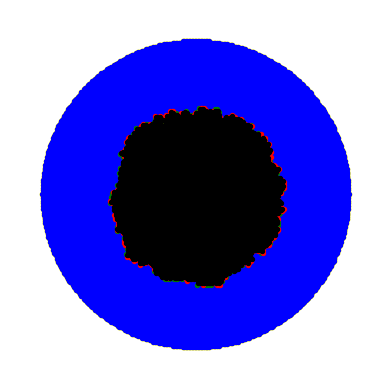

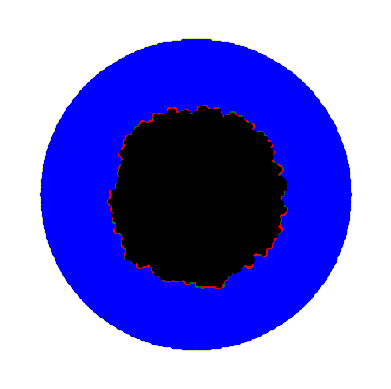

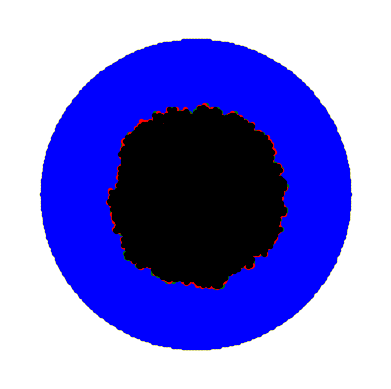

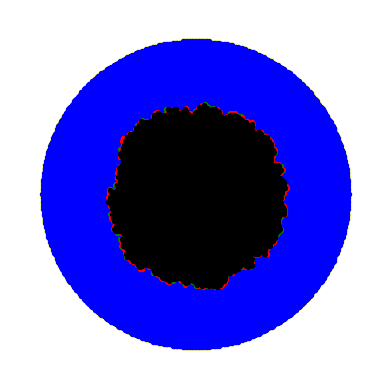

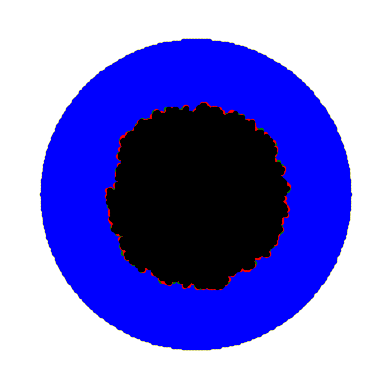

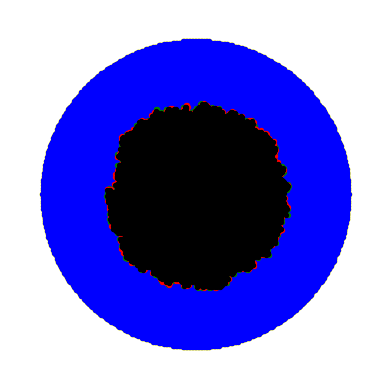

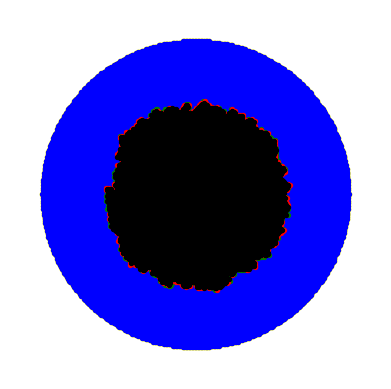

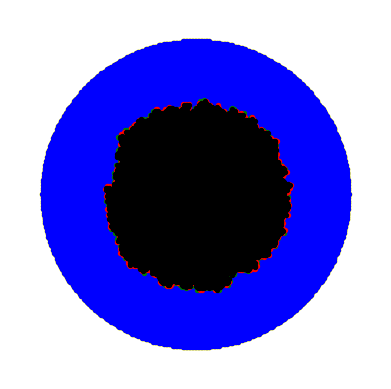

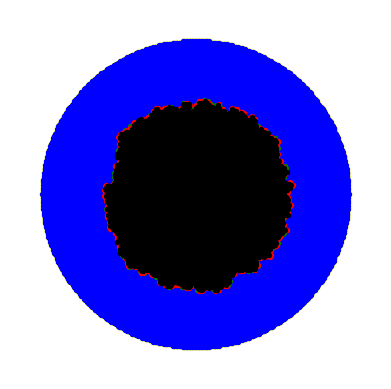

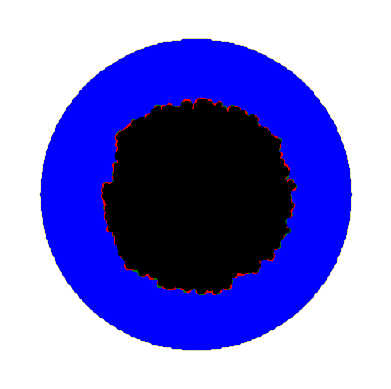

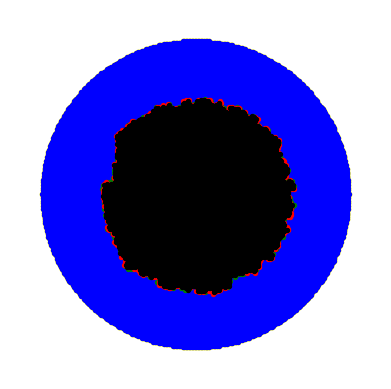

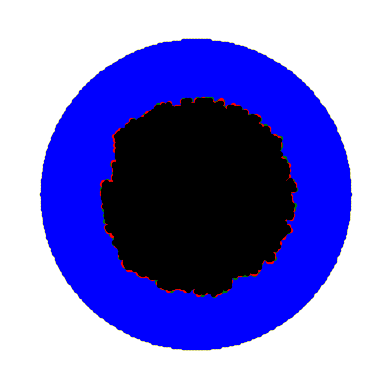

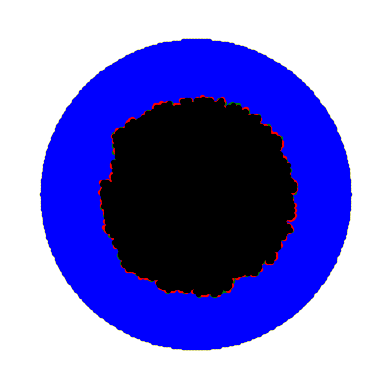

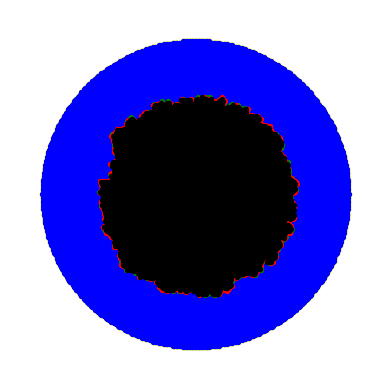

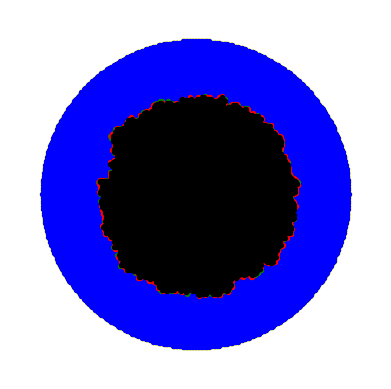

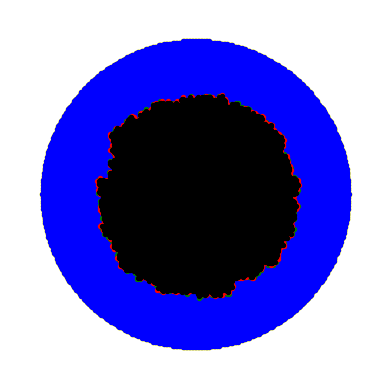

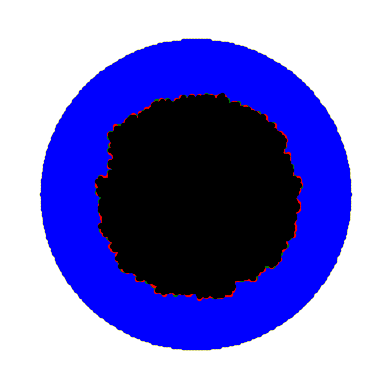

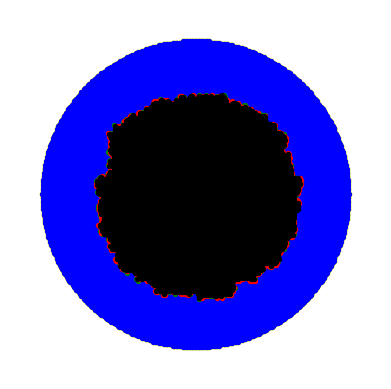

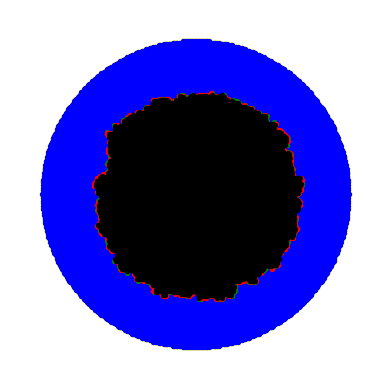

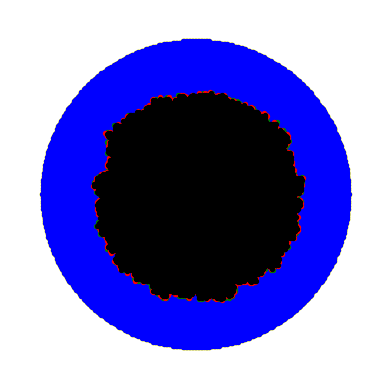

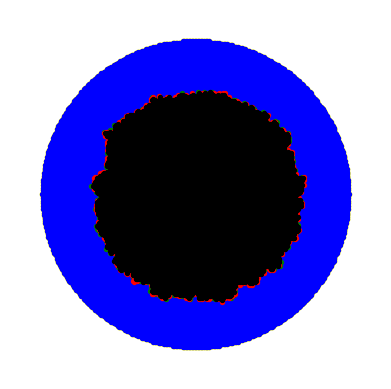

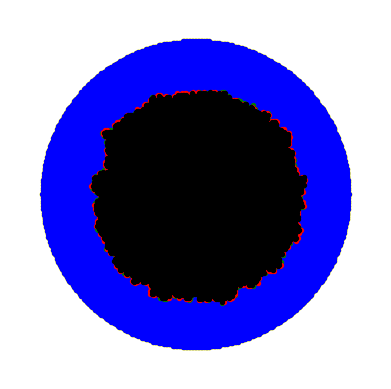

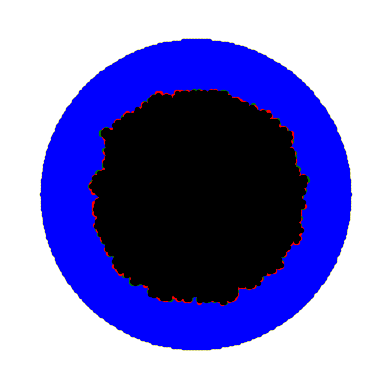

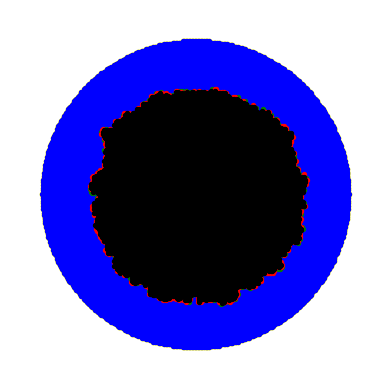

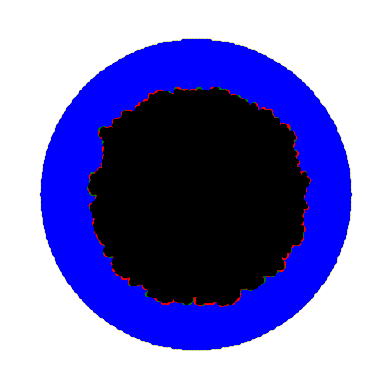

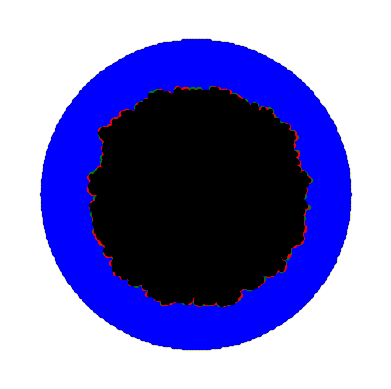

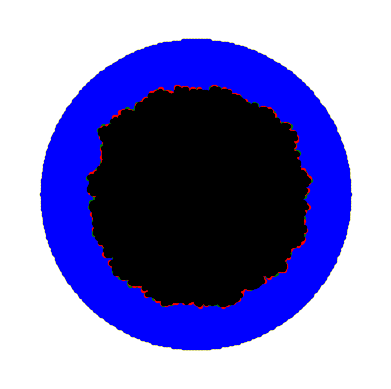

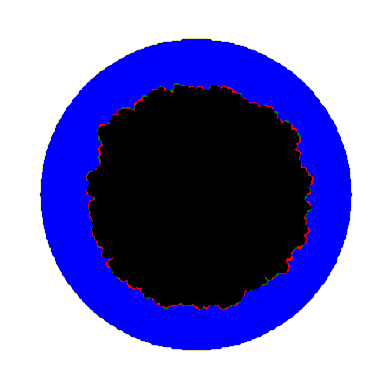

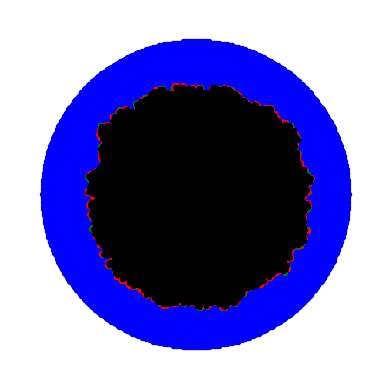

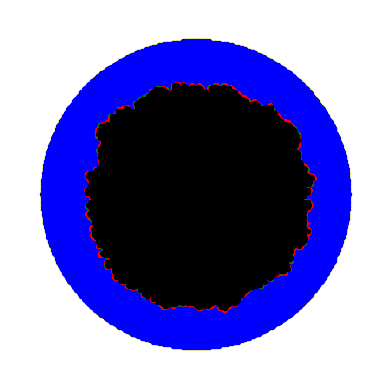

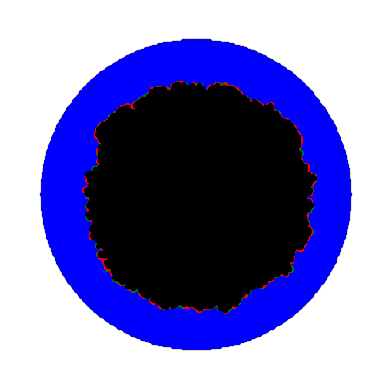

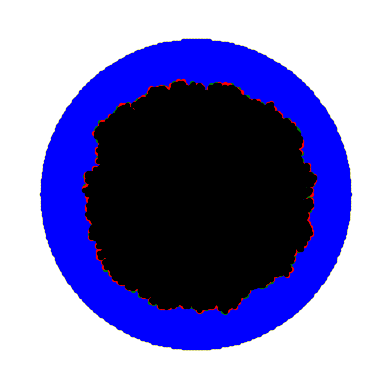

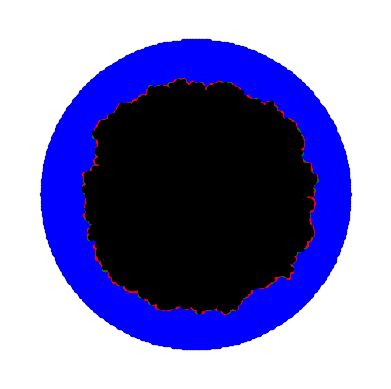

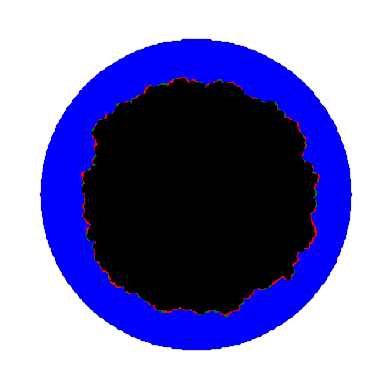

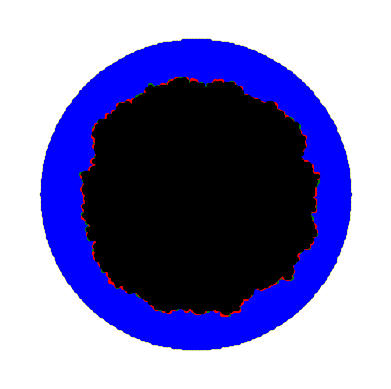

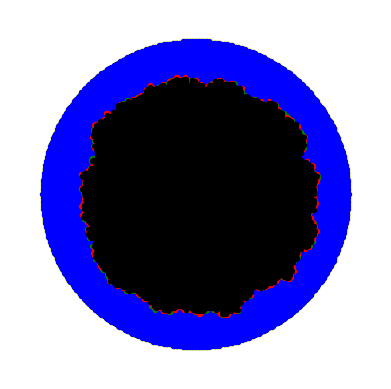

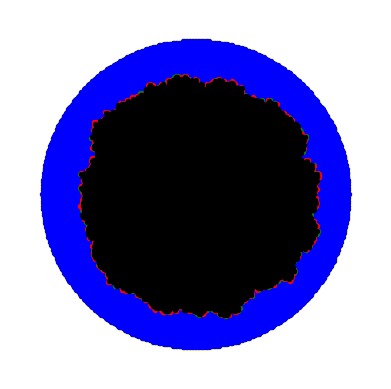

In [28]:
# 4000 lattice size로 100 step 했을 때 16시간 걸려도 결과 안나옴

path = '/Users/juseongkim/Documents/대학원/epidemic spreading/Epidemic_speading/result/Fig/'

v_type = 'EBOV'
# v_type = 'MARV'

# 최대 plate에 반지름에 해당하는 개수는 4337.5개 정도 해당하는 node로 원 그려야됨
radius =100
# 세로
h = 1000
# 가로
w = 2000
# 시뮬레이션 시간 한스텝이 일어나는 시간을 정해야되나? 어떻게 3시간뒤에 감염되고 24시간 이후에는 감염안되게 하는지 생각해보깆
num_steps = 100

# 확률로 하는데 맞나?
# S -> E paramter  감염율
if v_type == 'EBOV':
    beta = 0.5
elif v_type == 'MARV':
    beta = 0.41
# E -> I paramter 잠복기? 기간의 역수 -> 요것도 비율로 하는게 아니라 몇일이 지나면 바이러스 내보낼 수 있는 시간으로 
if v_type == 'EBOV':
    alpha=0.4
elif v_type == 'MARV':
    alpha=0.22
# I -> D parameter 회복률 -> 몇일 지나면 더이상 바이러스 못 시키는지로 바꿔야됨
if v_type == 'EBOV':
    gamma = 0.1
elif v_type == 'MARV':
    gamma = 0.2




# make triangular lattice
# 1000개의 사이즈로 만들면 65초정도 걸림
G = nx.triangular_lattice_graph(m=h, n=w, periodic=False, with_positions=True, create_using=None)
pos = nx.get_node_attributes(G, 'pos')


# center는 무조건 걸리게 해뒀음 나중에는 바꿀 꺼임
# infected = {infected_node} dictionary
# seed 가 3개다
# seed에서 반지름 길이에 해당하는 세포수는 0.23 / 0.004 = 57.5개 정도

##############
# 랜덤하게 여러개의 시드를 넣어주자
##############
# for i in range(seed_number):
#     # 지금은 가장자리에 잘 안 분포되게 해놓는게 좋을 거 같아서 1 l로 범위를 잡아높고 나중에 uniform distribution같은걸로 값을 넣어주는게 필요할 듯
#     G.nodes[(r.randrange(1,l),r.randrange(1,l))]['occupied'] = 1



# 반으로 줄였으니까 한 28개정도로 
center = (h//2+1, h//2+1)
center_pos = G.nodes[center]['pos']

circle_nodes = set()

for node, poss in pos.items():
    distance = math.sqrt((poss[0] - center_pos[0])**2 + (poss[1] - center_pos[1])**2)
    if distance <= radius:
        circle_nodes |= {node}

H = nx.subgraph(G, circle_nodes)


# infection
# # 직접적인 지정
# center1 = (h//2+1, h//2+1)
# center2 = (h//2-1, h//2-1)
# center3 = (h//2+1, h//2-1)
# center4 = (h//2-1, h//2+1)
# infected = {center}
# infected = {center, center1, center2, center3, center4}

# initial radius cell 갯수
infected = set()
# initail_radius는 위의 전체 radius보다는 항상 작아야됨
initial_radius = 20
# 이 안의 범위에 들어오는것은 저렇게 해줘
for node, poss in pos.items():
    distance = math.sqrt((poss[0] - center_pos[0])**2 + (poss[1] - center_pos[1])**2)
    if distance <= initial_radius:
        infected |= {node}

# # 이런식으로 추가 가능
# t = (9,9)
# et = {t}
# E |= et

# initial population setting
S = set(H.nodes()) - infected
E = set()
I = infected
D = set()

# for record population
sus_list = []
exposed_list = []
infected_list = []
dead_list = []

# 처음 모습
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# nx.draw(H, pos, node_size=10, node_color='yellow', with_labels=False)
# nx.draw_networkx_nodes(H, pos, nodelist=S, node_size=8, node_color='blue')     
# nx.draw_networkx_nodes(H, pos, nodelist=E, node_size=8, node_color='green')
# nx.draw_networkx_nodes(H, pos, nodelist=I, node_size=8, node_color='red')
# nx.draw_networkx_nodes(H, pos, nodelist=D, node_size=8, node_color='black')

# 이거 순서도 생각해야됨
for t in range(num_steps):

    # # E -> I initial time
    # new_infections = set()

    # for e in E:
    #     if np.random.choice([0,1], 1, p = [1-alpha, alpha]):
    #     # if np.random.uniform() > beta:
    #         new_infections.add(e)

    # E -= new_infections
    # I |= new_infections

    # S -> E process
    new_exposed = set()

    for s in S:
        # s의 이웃들에 대해서
        for neighbor in H.neighbors(s):
            # neighbor에서 E 혹은 I가 있으면 감염시켜라 그러면 E 빼야되는거 아닌가? 이건 고민좀 해봐야될 듯?
            # if neighbor in I or neighbor in E:
            if neighbor in I:
                #if np.random.choice([0,1], 1, p = [1-beta, beta]):
                if np.random.uniform() > beta:
                    new_exposed.add(s)
                    # break 들어가는 이유 그 다음 스텝 추가 했으면 그건 다시 감염 안시켜서 한번에 하나만 감염시킬 수 있게 해주기 위해서 들어감
                    # 한step에 빨간 녀석은 한명만 감염시킬 수 있음.
                    # break 없앰

    S -= new_exposed
    E |= new_exposed
    
    # I -> R process
    new_recoveries = set()

    for i in I:
        # if np.random.choice([0,1], 1, p = [1-gamma, gamma]):
        if np.random.uniform() > gamma:
            new_recoveries.add(i)

    I -= new_recoveries
    D |= new_recoveries



    # E -> I process
    new_infections = set()

    for e in E:
        # if np.random.choice([0,1], 1, p = [1-alpha, alpha]):
        if np.random.uniform() > alpha: 
            new_infections.add(e)

    E -= new_infections
    I |= new_infections

    # 각 step에서의 갯수 기록
    sus_list.append(len(S))
    exposed_list.append(len(E))
    infected_list.append(len(I))
    dead_list.append(len(D))

    # Draw Figures
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    nx.draw(H, pos, node_size=10, node_color='yellow', with_labels=False)
    nx.draw_networkx_nodes(H, pos, nodelist=S, node_size=8, node_color='blue')     
    nx.draw_networkx_nodes(H, pos, nodelist=E, node_size=8, node_color='green')
    nx.draw_networkx_nodes(H, pos, nodelist=I, node_size=8, node_color='red')
    nx.draw_networkx_nodes(H, pos, nodelist=D, node_size=8, node_color='black')
        # plt.savefig(path + f'SEIR_{t}.png')

# 비율 시각화

Text(0, 0.5, 'number of state')

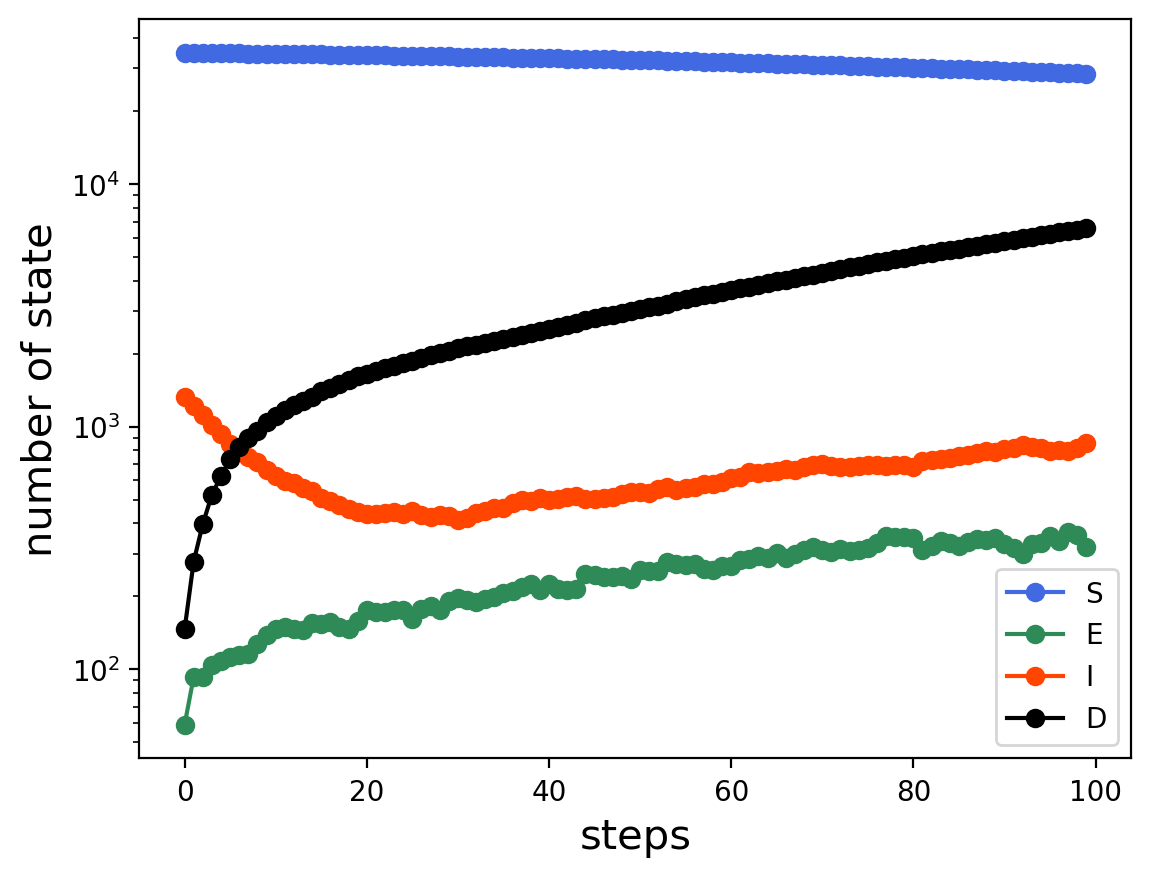

In [18]:
plt.figure(dpi=200)
plt.plot(np.arange(0,num_steps,1),sus_list, marker='o', label='S',color='royalblue')
plt.plot(np.arange(0,num_steps,1),exposed_list, marker='o', label='E', color='seagreen')
plt.plot(np.arange(0,num_steps,1),infected_list, marker='o', label='I', color='orangered')
plt.plot(np.arange(0,num_steps,1),dead_list, marker='o', label='D', color='black')
plt.legend()
plt.yscale('log')
# plt.title(f"{num_steps}steps beta = {beta}, alpha={alpha}, gamma={gamma} Lattice size = {h}", fontsize=17)
plt.xlabel('steps', fontsize=15)
plt.ylabel('number of state', fontsize=15)
# plt.tight_layout(pad=0.4, w_pad=20, h_pad=1.0)
# plt.savefig('../result/simulation ratio')

# GIF 파일 생성 ( 시뮬레이션 )

In [101]:
import imageio
import os
import natsort

path = '/Users/juseongkim/Documents/대학원/epidemic spreading/Epidemic_speading/result/Fig/'
file_list = os.listdir(path)

file_list_png = [file for file in file_list if file.endswith(".png")]
file_list_png = natsort.natsorted(file_list_png)

In [102]:
directory = '/Users/juseongkim/Documents/대학원/epidemic spreading/Epidemic_speading/result/Fig/'
image_type = '.png'
gif_name = 'SEIR model simulation1'
speed_sec = { 'duration': 0.2 } #사진 넘기는 시간

images = []

for file in file_list_png:
  file_path = os.path.join(directory, file)
  images.append(imageio.imread(file_path))
imageio.mimsave('{0}/{1}.gif'.format(directory, gif_name), images, **speed_sec)

/var/folders/7w/f3yz5lls31n4jsq13_dmd6z40000gn/T/ipykernel_1770/107507515.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


# Dead 상태를 바탕으로 반지름 구하기

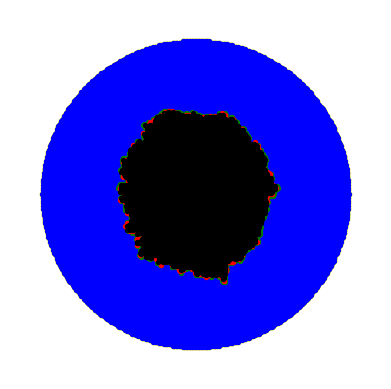

In [12]:
# 특정시점까지 시뮬레이션을 하고 그이후에 거리에 따라서 각각의 노드의 개수를 세면 된다?

fig, ax = plt.subplots()
ax.set_aspect('equal')
nx.draw(H, pos, node_size=10, node_color='yellow', with_labels=False)
nx.draw_networkx_nodes(H, pos, nodelist=S, node_size=8, node_color='blue')     
nx.draw_networkx_nodes(H, pos, nodelist=E, node_size=8, node_color='green')
nx.draw_networkx_nodes(H, pos, nodelist=I, node_size=8, node_color='red')
nx.draw_networkx_nodes(H, pos, nodelist=D, node_size=8, node_color='black')

# radius-SEID graph

In [ ]:
nx.set_node_attributes(H, values={(i,j): {'shortest path length' :nx.shortest_path_length(H, center, target=(i,j))} for i,j in H.nodes})

In [13]:
# radius 기준으로 다시 subgraph를 그리고 그안에서 겹치는 것들에 대해서 카운트한다 라고 하면 안되지

# 해당 위치에 해당할 때 니까 이건

# 그러면 결국에 이전에 있었던 그래프를 빼주면 되곘네?

pos_H = nx.get_node_attributes(H, 'pos')

r_sus = []
r_ex = []
r_infec = []
r_dead = []

# 모든 radus를 정수단위로 나눠서 보자?
for q in np.arange(1, radius+1):
    # 이전 radius에서의 노드집합을 기억한다.
    previous = circle_nodes
    # 해당 radius 이내에 해당하는 노드를 넣을 빈 집합을 만든다.
    circle_nodes = set()

    # 해당 노드의 id와 위치를 얻는다
    for nodeh, posh in pos_H.items():
        # 중심과 해당 노드와의 거리를 잰다
        distance = math.sqrt((posh[0] - center_pos[0])**2 + (posh[1] - center_pos[1])**2)
        # 만약에 그렇게 잰 거리가 기준인 radius보다 작다면
        if distance <= q:
            # 그런 노드를 업데이트해서 
            circle_nodes |= {nodeh}
    
    J = nx.subgraph(H, circle_nodes.difference(previous))

    r_sus.append(set(J.nodes).intersection(S))
    r_ex.append(set(J.nodes).intersection(E))
    r_infec.append(set(J.nodes).intersection(I))
    r_dead.append(set(J.nodes).intersection(D))

In [14]:
r_suss = []
for i in range(len(r_sus)):
    r_suss.append(len(r_sus[i]))

r_exx = []
for i in range(len(r_ex)):
    r_exx.append(len(r_ex[i]))

r_infecc = []
for i in range(len(r_infec)):
    r_infecc.append(len(r_infec[i]))


r_deadd = []
for i in range(len(r_dead)):
    r_deadd.append(len(r_dead[i]))

Text(0, 0.5, 'number of state')

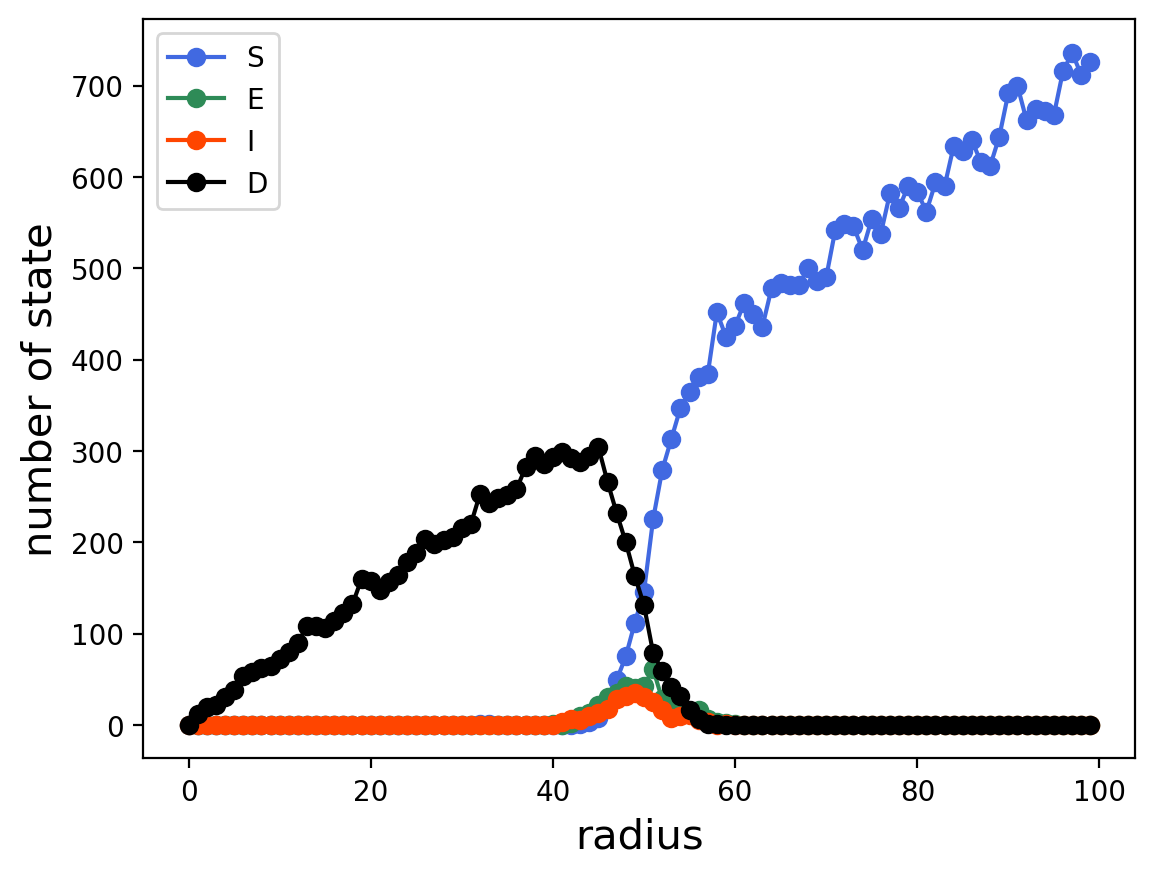

In [15]:
plt.figure(dpi=200)
plt.plot(np.arange(0,radius,1),r_suss, marker='o', label='S',color='royalblue')
plt.plot(np.arange(0,radius,1),r_exx, marker='o', label='E', color='seagreen')
plt.plot(np.arange(0,radius,1),r_infecc, marker='o', label='I', color='orangered')
plt.plot(np.arange(0,radius,1),r_deadd, marker='o', label='D', color='black')
plt.legend()
# plt.title(f"{num_steps}steps beta = {beta}, alpha={alpha}, gamma={gamma} Lattice size = {h}", fontsize=17)
plt.xlabel('radius', fontsize=15)
plt.ylabel('number of state', fontsize=15)
# plt.tight_layout(pad=0.4, w_pad=20, h_pad=1.0)
# plt.savefig('../result/simulation ratio')